# Imports


In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.spatial.distance import mahalanobis

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.decomposition import PCA


# Helping functions

In [74]:
def model_hendling(modelname, params, X_train, X_test, y_train, y_test):

    best_f1 = 0
    best_params = {}
    best_model = None
    best_preds = None
    if modelname == "SVC":
        for c in params["C"]:
            for g in params["gamma"]:
                for k in params["kernel"]:
                    model = SVC(C=c, gamma=g, kernel=k)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    f1 = f1_score(y_test, y_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {"C" : c, "gamma" : g, "kernel" : k}
                        best_model = model
                        best_preds = y_pred

    elif modelname == "LogReg":
        for c in params["C"]:
            model = LogisticRegression(C=c)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_params = {"C" : c}
                best_model = model
                best_preds = y_pred

    elif modelname == "KNN":
        for n in params["Neighbours amount"]:
            model = KNeighborsClassifier(n_neighbors=n)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_params = {"Neighbours amount" : n}
                best_model = model
                best_preds = y_pred

    elif modelname == "One-class SVC":
        for nu in params["nu"]:
            for g in params["gamma"]:
                for k in params["kernel"]:
                    model = OneClassSVM(nu=nu, gamma=g, kernel=k)
                    y_pred = model.fit_predict(np.concatenate((X_train, X_test), axis=0))
                    #map nd array change -1 to 1 and 1 to 0
                    y_pred = np.where(y_pred == 1, 0, 1)
                    f1 = f1_score(np.concatenate((y_train, y_test), axis=0), y_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {"nu" : nu, "gamma" : g, "kernel" : k}
                        best_model = model
                        best_preds = y_pred


    elif modelname == "IsolationForest":
        for n in params["n_estimators"]:
            for s in params["max_samples"]:
                for c in params["contamination"]:
                    model = IsolationForest(n_estimators=n, max_samples=s, contamination=c)
                    y_pred = model.fit_predict(np.concatenate((X_train, X_test), axis=0))
                    #map nd array change -1 to 1 and 1 to 0
                    y_pred = np.where(y_pred == 1, 0, 1)
                    f1 = f1_score(np.concatenate((y_train, y_test), axis=0), y_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {"n_estimators" : n, "max_samples" : s, "contamination" : c}
                        best_model = model
                        best_preds = y_pred
                    
    
    else:
        print("Not able to recognize modelname")

    print(modelname)
    if modelname == "One-class SVC" or modelname == "IsolationForest":
        print(confusion_matrix(np.concatenate((y_train, y_test), axis=0), best_preds))  
        print(classification_report(np.concatenate((y_train, y_test), axis=0), best_preds))
    else:
        print(confusion_matrix(y_test, best_preds))  
        print(classification_report(y_test, best_preds))              
    print(f"Best F1 score: {best_f1}")
    print(f"Best params: {best_params}")
    return best_model, best_preds

# Data


In [75]:
df = pd.read_csv('Cardiotocography.csv')
df.head()

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,outlier
0,1881.0,0.592593,0.000000,0.000000,0.294118,0.633803,0.338235,0.000000,0.013807,0.500000,...,0.045872,0.336207,0.333333,0.1,0.485149,0.247423,0.284091,0.638418,1.0,b'yes'
1,421.0,0.574074,0.038462,0.000000,0.000000,0.816901,0.029412,0.527473,0.092702,0.000000,...,0.770642,0.672414,0.166667,0.0,0.534653,0.587629,0.511364,0.016949,0.0,b'yes'
2,92.0,0.777778,0.000000,0.000000,0.000000,0.774648,0.029412,0.736264,0.096647,0.000000,...,0.816514,0.275862,0.222222,0.0,0.633663,0.659794,0.602273,0.000000,1.0,b'yes'
3,1767.0,0.259259,0.000000,0.000000,0.294118,0.704225,0.191176,0.000000,0.183432,0.428571,...,0.174312,0.275862,0.222222,0.1,0.000000,0.164948,0.000000,0.361582,0.0,b'yes'
4,1880.0,0.592593,0.000000,0.001773,0.294118,0.633803,0.352941,0.000000,0.013807,0.428571,...,0.045872,0.336207,0.333333,0.1,0.485149,0.226804,0.272727,0.683616,1.0,b'yes'


# EDA & Data preprocessing

In [76]:
"""Should map target from "yes/no" to 1/0. No Nan values, so no need to handle them"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

In [77]:
"""Everything except "id" is already scaled in range 0-1."""
df.describe()

,id,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,...,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,1123.872156,0.483186,0.129270,0.011411,0.226668,0.425672,0.179521,0.064739,0.170819,0.113227,...,0.391083,0.379411,0.365604,0.230579,0.033365,0.563887,0.525497,0.475086,0.090984,0.670794
std,593.610901,0.175738,0.143077,0.060514,0.156665,0.216970,0.121198,0.146732,0.114551,0.171935,...,0.214992,0.252147,0.153285,0.159211,0.069209,0.128429,0.136375,0.146790,0.119737,0.295171
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,641.000000,0.351852,0.000000,0.000000,0.117647,0.236111,0.088235,0.000000,0.094675,0.000000,...,0.204678,0.155963,0.258621,0.111111,0.000000,0.482143,0.431193,0.373494,0.015385,0.500000
50%,1150.500000,0.481481,0.076923,0.000000,0.235294,0.408451,0.161765,0.000000,0.155819,0.000000,...,0.377907,0.376147,0.353448,0.222222,0.000000,0.567797,0.525773,0.478261,0.045198,0.500000
75%,1619.000000,0.592593,0.192308,0.003546,0.304348,0.608108,0.220588,0.050633,0.226824,0.214286,...,0.549133,0.596330,0.456897,0.333333,0.000000,0.650000,0.621053,0.576087,0.122677,1.000000
max,2126.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
# Mapping target
df['outlier'] = df['outlier'].map({"b'yes'" : 1, "b'no'" : 0})

# Removing id, since it doesn't contain useful information for us.
df = df.drop(columns=['id'])

"""Not balanced :("""
# Check target distribution
df['outlier'].value_counts()

outlier
0    16550
1      330
Name: count, dtype: int64

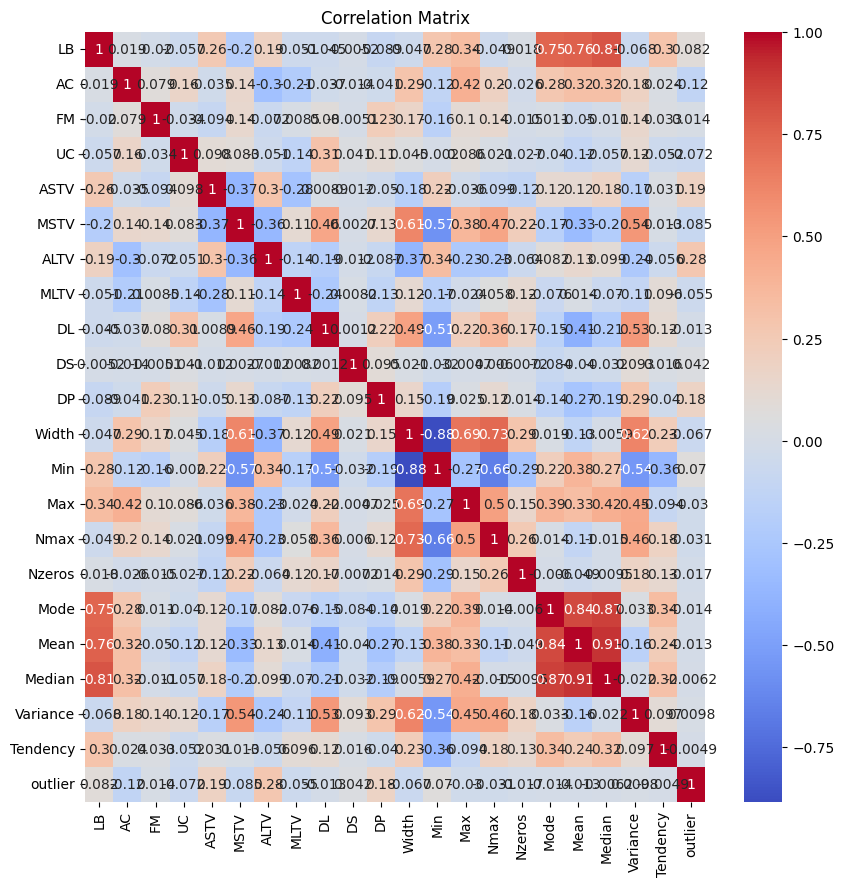

In [79]:
"""We can observe some strong correlations, probably, i will remove some features to reduce multicolinearity"""
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

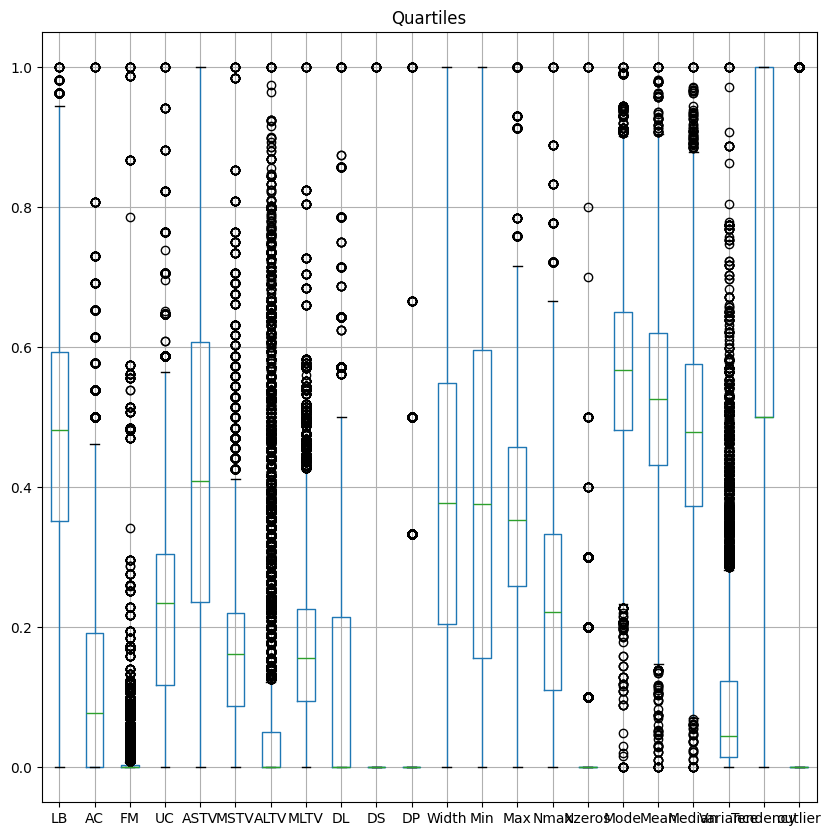

In [80]:
"""Looks messy but it's ok"""
# Plotting quartiles 
plt.figure(figsize=(10, 10))
df.boxplot()
plt.title('Quartiles')
plt.show()

In [81]:
# Data split
target = 'outlier'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# Feature engineering

In [82]:
# Adding some non-linearity
for column in df.columns:
    if column in ["outlier"]:
        continue
    df[column + "_2"] = df[column] ** 2

# Mehalanobis rule

In [83]:
# Compute Mehalanobis distance
codence = np.cov(df.values.T)
inv_codence = np.linalg.inv(codence)
maha = []
for row in df.values:
    maha.append(mahalanobis(row, np.mean(df.values, axis=0), inv_codence))

df['maha'] = maha
print(df['maha'].describe())
df.head()

count    16880.000000
mean         5.853948
std          2.879241
min          2.634545
25%          4.320924
50%          5.156970
75%          6.460693
max         47.657780
Name: maha, dtype: float64


,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min_2,Max_2,Nmax_2,Nzeros_2,Mode_2,Mean_2,Median_2,Variance_2,Tendency_2,maha
0,0.592593,0.000000,0.000000,0.294118,0.633803,0.338235,0.000000,0.013807,0.500000,0.0,...,0.002104,0.113035,0.111111,0.01,0.235369,0.061218,0.080708,0.407578,1.0,12.752567
1,0.574074,0.038462,0.000000,0.000000,0.816901,0.029412,0.527473,0.092702,0.000000,0.0,...,0.593889,0.452140,0.027778,0.00,0.285854,0.345308,0.261493,0.000287,0.0,12.255669
2,0.777778,0.000000,0.000000,0.000000,0.774648,0.029412,0.736264,0.096647,0.000000,0.0,...,0.666695,0.076100,0.049383,0.00,0.401529,0.435328,0.362732,0.000000,1.0,9.605641
3,0.259259,0.000000,0.000000,0.294118,0.704225,0.191176,0.000000,0.183432,0.428571,0.0,...,0.030385,0.076100,0.049383,0.01,0.000000,0.027208,0.000000,0.130741,0.0,18.211587
4,0.592593,0.000000,0.001773,0.294118,0.633803,0.352941,0.000000,0.013807,0.428571,0.0,...,0.002104,0.113035,0.111111,0.01,0.235369,0.051440,0.074380,0.467331,1.0,13.843185


# SVM

In [84]:
# Parameters
params_SVC = {"C" : [0.1, 1, 10, 100], "gamma" : [0.1, 1, 10, 100], "kernel" : ['linear', 'rbf', 'poly']}

best_SVC_model, best_SVC_preds = model_hendling("SVC", params_SVC, X_train, X_test, y_train, y_test)


SVC
[[4965    0]
 [  21   78]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4965
           1       1.00      0.79      0.88        99

    accuracy                           1.00      5064
   macro avg       1.00      0.89      0.94      5064
weighted avg       1.00      1.00      1.00      5064

Best F1 score: 0.8813559322033898
Best params: {'C': 0.1, 'gamma': 10, 'kernel': 'poly'}


# LogReg

In [85]:
# Parameters
logreg_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

best_logreg_model, best_logreg_preds = model_hendling("LogReg", logreg_params, X_train, X_test, y_train, y_test)

LogReg
[[4958    7]
 [  53   46]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4965
           1       0.87      0.46      0.61        99

    accuracy                           0.99      5064
   macro avg       0.93      0.73      0.80      5064
weighted avg       0.99      0.99      0.99      5064

Best F1 score: 0.6052631578947368
Best params: {'C': 1000}


# KNN

In [86]:
# Parameters
k_neighbours = {"Neighbours amount" : [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

best_knn_model, best_knn_preds = model_hendling("KNN", k_neighbours, X_train, X_test, y_train, y_test)

KNN
[[4965    0]
 [  37   62]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4965
           1       1.00      0.63      0.77        99

    accuracy                           0.99      5064
   macro avg       1.00      0.81      0.88      5064
weighted avg       0.99      0.99      0.99      5064

Best F1 score: 0.7701863354037267
Best params: {'Neighbours amount': 3}


# One-class SVM

In [87]:
# Parameters for One-class SVM
params_one_class_SVM = {"nu" : [0.1, 0.2, 0.3, 0.4, 0.5], "gamma" : [0.1, 1, 10, 100],  "kernel" : ['linear', 'rbf', 'poly']}

best_one_class_SVM_model, best_one_class_SVM_preds = model_hendling("One-class SVC", params_one_class_SVM, X_train, X_test, y_train, y_test)

One-class SVC
[[15052  1498]
 [  139   191]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     16550
           1       0.11      0.58      0.19       330

    accuracy                           0.90     16880
   macro avg       0.55      0.74      0.57     16880
weighted avg       0.97      0.90      0.93     16880

Best F1 score: 0.1892025755324418
Best params: {'nu': 0.1, 'gamma': 1, 'kernel': 'rbf'}


# Isolation tree

In [94]:
# Parameters for Isolation Forest
params_isolation_forest = {"n_estimators" : [100, 200, 300], "max_samples" : [100, 200, 300], "contamination" : [0.01, 0.1, 0.2]}

best_isolation_forest_model, best_isolation_forest_preds = model_hendling("IsolationForest", params_isolation_forest, X_train, X_test, y_train, y_test)


IsolationForest
[[16425   125]
 [  286    44]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16550
           1       0.26      0.13      0.18       330

    accuracy                           0.98     16880
   macro avg       0.62      0.56      0.58     16880
weighted avg       0.97      0.98      0.97     16880

Best F1 score: 0.17635270541082165
Best params: {'n_estimators': 300, 'max_samples': 200, 'contamination': 0.01}


# Visualization of predictions

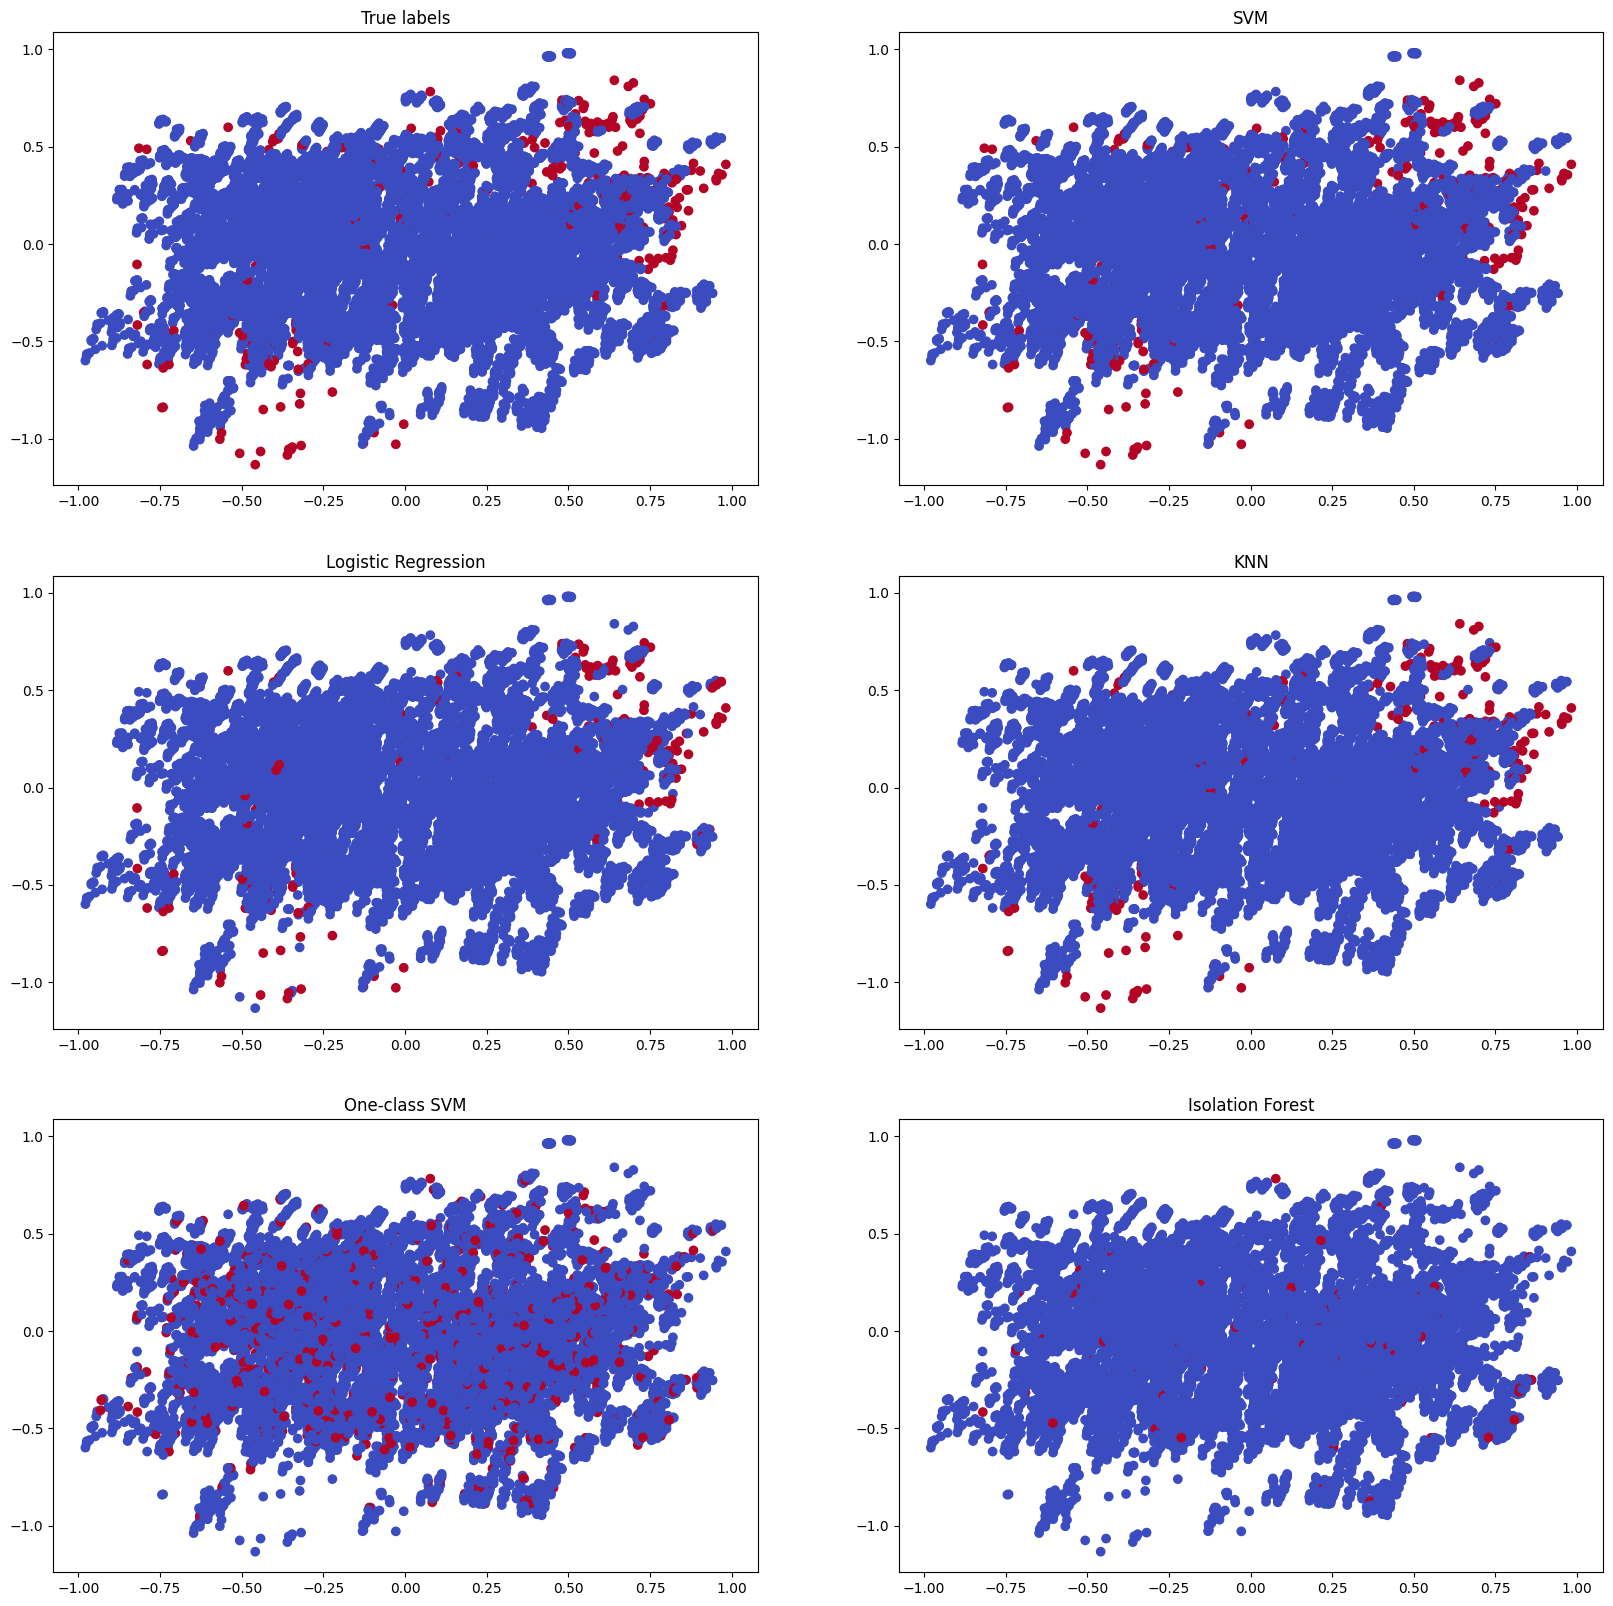

In [95]:
# PCA for dimensionality reduction and then visualization

y_SVM = best_SVC_model.predict(X)
y_logreg = best_logreg_model.predict(X)
y_knn = best_knn_model.predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting for each model and PCA
plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
plt.title('True labels')

plt.subplot(3, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_SVM, cmap='coolwarm')
plt.title('SVM')

plt.subplot(3, 2, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_logreg, cmap='coolwarm')
plt.title('Logistic Regression')

plt.subplot(3, 2, 4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_knn, cmap='coolwarm')
plt.title('KNN')

plt.subplot(3, 2, 5)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_one_class_SVM_preds, cmap='coolwarm')
plt.title('One-class SVM')

plt.subplot(3, 2, 6)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_isolation_forest_preds, cmap='coolwarm')
plt.title('Isolation Forest')

plt.show()



# Conclusions

Main assessment criteria was confusion matrix and amount of True Negative classes because it is the most usefull in outliers detection task. Also final visualizsation helped to consider models performance. 
Supervised:
If we are talking about best results, then first place goes to SVM, second to KNN and third to the LogReg, algtough every model showed great results. But training time is the fastest for LogReg, slower for KNN and much more slower for SVM. So we should choose the model due to our priorities.
Unsupervised:
Besides grid search for params both models showed horrible results. Isolation forest could be better, if we had more outliers, we can observe it from the statistics, which shows, that it almost alsways picks overwelming class.
Problems with this model could be due to unbalanced dataset or wrong feature engineering, though I used same for supervised models.